In [ ]:
!pip install datasets transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
!python parsing.py

Parse all scripts from this website https://fangj.github.io/friends/
Total: 100% 228/228 [00:45<00:00,  5.00it/s]
Number of characters in dataframe 196
100% 6/6 [00:01<00:00,  4.58it/s]
script created


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import random
from typing import Callable, Iterable
import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Searching section

In [ ]:
[CLS][Rachel] sentence [Ross] sentence [Rachel] sentence [Ross] sentence [Rachel] sentence [Ross] sentence [Rachel] sentence  [Ross] sentence [SEP] max_length = 128

In [ ]:
dict(sorted(tokenizer.vocab.items(), key=lambda item: item[1]))

In [ ]:
[atr for atr in tokenizer.__dir__() if "add" in atr]

In [ ]:
tokenizer.vocab

Add tokens with the names of actors to tokenizer vocab.

In [ ]:
characters = ["rachel", "ross", "joey", "monica", "chandler", "phoebe"]

In [ ]:
for char in characters:
  if char in tokenizer.vocab.keys():
    print(f"{char} is already in vocab")
  else:
    print(f"{char} should be added to vocab")

rachel is already in vocab
ross is already in vocab
joey is already in vocab
monica is already in vocab
chandler is already in vocab
phoebe is already in vocab


In [ ]:
df = pd.read_csv("rachel_friends_label.csv")
type(df.question[0]), type(df.answer[0])

(str, str)

In [ ]:
%%time
MAX_LENGTH = 128

tokenized_questions = tokenizer(df.question.tolist(),
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True)

tokenized_answers = tokenizer(df.answer.tolist(),
                                 max_length=MAX_LENGTH, padding="max_length",
                                 truncation=True, verbose=True)

CPU times: user 3.59 s, sys: 716 ms, total: 4.3 s
Wall time: 3.38 s


In [ ]:
tokenized_questions[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
class FriendsDataset(Dataset):
    def __init__(self, questions_tokens: dict, answers_tokens: dict, labels: Iterable[str]):
        self.questions_tokens = questions_tokens
        self.answers_tokens = answers_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for qt_ids, qt_am, at_ids, at_am, labels in zip(
            self.questions_tokens["input_ids"], self.questions_tokens["attention_mask"],
            self.answers_tokens["input_ids"], self.answers_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["question_input_ids"] = torch.tensor(qt_ids, dtype=torch.long)
            data["question_attention_mask"] = torch.tensor(qt_am, dtype=torch.long)
            data["answer_input_ids"] = torch.tensor(at_ids, dtype=torch.long)
            data["answer_attention_mask"] = torch.tensor(at_am, dtype=torch.long)
            data["labels"] = torch.tensor(labels, dtype=torch.float)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
friends_dataset = FriendsDataset(tokenized_questions, tokenized_answers, df.label.tolist())

Split data to train and val

In [ ]:
train_ratio = 0.8
n_total = len(friends_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(friends_dataset, [n_train, n_val])

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"Batches in dataset: {n_total/batch_size}")

Batches in dataset: 1007.375


Define device for calculation

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [ ]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 1)
        # self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        question_input_ids = data["question_input_ids"].to(device)
        question_attention_mask = data["question_attention_mask"].to(device)
        answer_input_ids = data["answer_input_ids"].to(device)
        answer_attention_mask = data["answer_attention_mask"].to(device)

        out_question = self.bert_model(question_input_ids, question_attention_mask)
        out_answer = self.bert_model(answer_input_ids, answer_attention_mask)
        question_embeds = out_question.last_hidden_state
        answer_embeds = out_answer.last_hidden_state

        pooled_question_embeds = mean_pool(question_embeds, question_attention_mask)
        pooled_answer_embeds = mean_pool(answer_embeds, answer_attention_mask)

        embeds =  torch.cat([pooled_question_embeds, pooled_answer_embeds,
                             torch.abs(pooled_question_embeds - pooled_answer_embeds)],
                            dim=-1)
        # return self.sigmoid(self.linear(embeds))
        return self.linear(embeds)

In [ ]:
model = Sbert().to(device)
print(f"hidden size of the model is {model.bert_model.config.hidden_size}")

hidden size of the model is 768


In [ ]:
# if we add new tokense than update model knowledge about it
# model.bert_model.resize_token_embeddings(len(tokenizer))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

# loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.MSELoss()

In [ ]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y.float().reshape(-1,1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y.float().reshape(-1,1))
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["labels"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 10) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

Launch training process

In [ ]:
%%time

n_epochs = 1  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/806, loss =  0.982
step   160/806, loss =  0.354
step   320/806, loss =  0.236
step   480/806, loss =  0.257
step   640/806, loss =  0.244
step   800/806, loss =  0.246

Validating ...
step     0/202, loss =  0.238
step   160/202, loss =  0.272
CPU times: user 4min 42s, sys: 3.13 s, total: 4min 45s
Wall time: 5min 4s


In [ ]:
model.bert_model.save_pretrained("models/friends_bi_encoder")

In [ ]:
window_size = 64

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

Text(0.5, 1.0, 'Loss on Bi-encoder model')

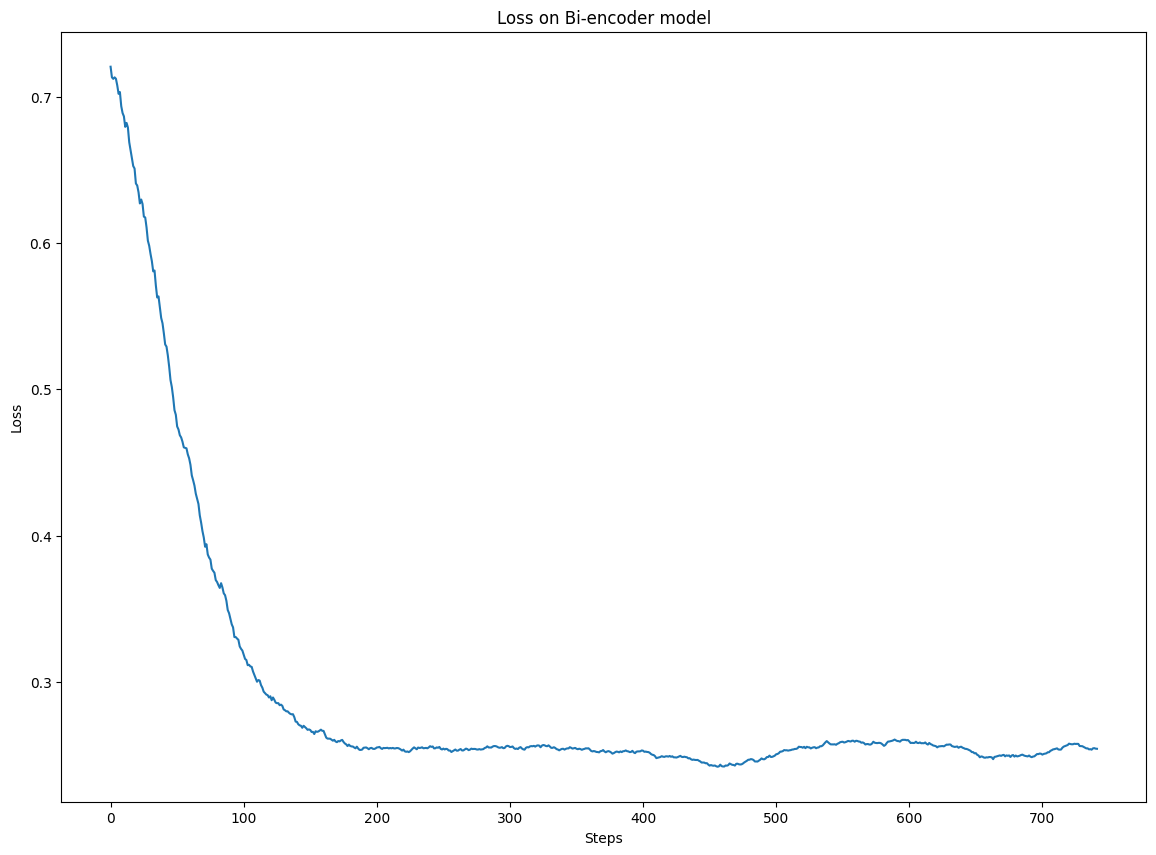

In [ ]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);
ax.set_xlabel("Steps");
ax.set_ylabel("Loss");
ax.set_title("Loss on Bi-encoder model")

In [ ]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

In [ ]:
sentences = [
    "wh? monday, one day. tuesday, two day. wednesday, when huh what? thurs— oh!",
    "come on joey!!!",
    "but people that you dont know and will never see again.",
    "yes, but still. theyre people…with eyes",
    "you had no right to tell me you ever had feelings for me.",
    "what?",
    "oh, i know, we should have been more prepared. its okay. now, the way i see it, our real competition now is cameron. oh my god, they just took her sweater off. look at those arms! hello michelin man.",
    "oh, phoebe! come on! you know what, its already three oclock and they havent even gotten to emmas group yet. we gotta go, we got dinner!",
    "you kissed him?",
    "yeah. it was after the party, we were on the balcony and..."
]

In [ ]:
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

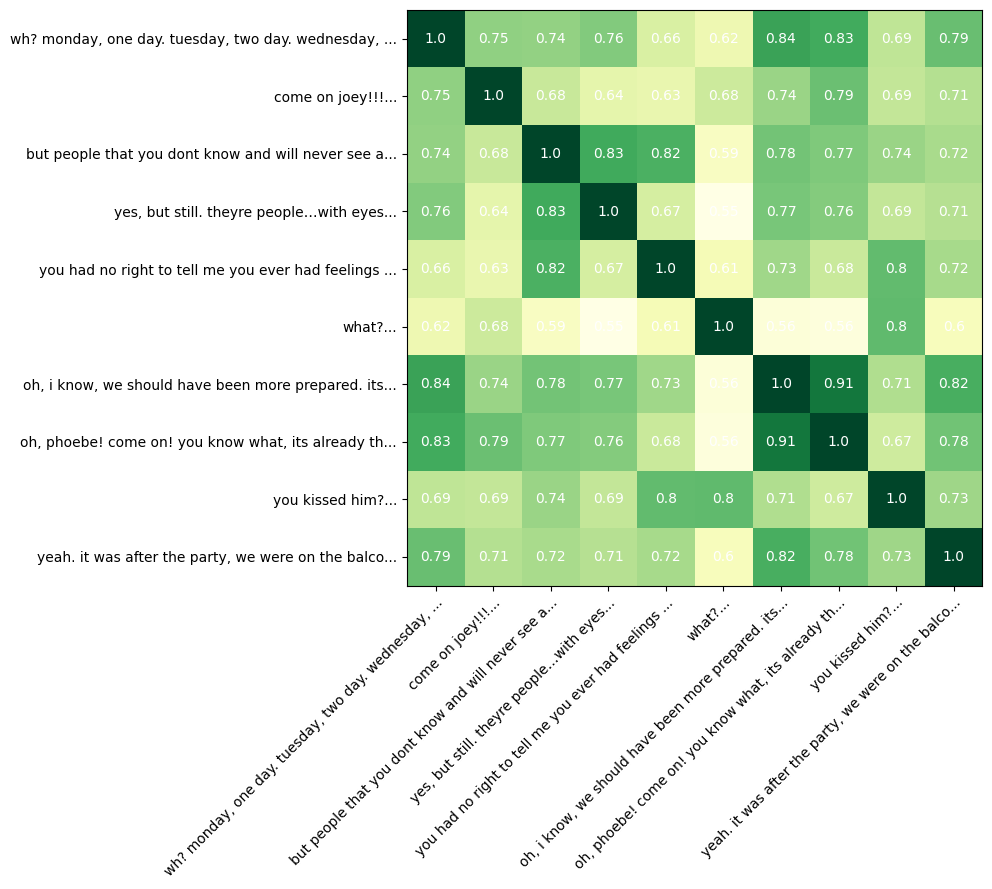

In [ ]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

Try without training

In [ ]:
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

In [ ]:
pooled_embeds = encode(sentences, tokenizer, bert_model, "cpu")
pooled_embeds = pooled_embeds.detach().numpy()

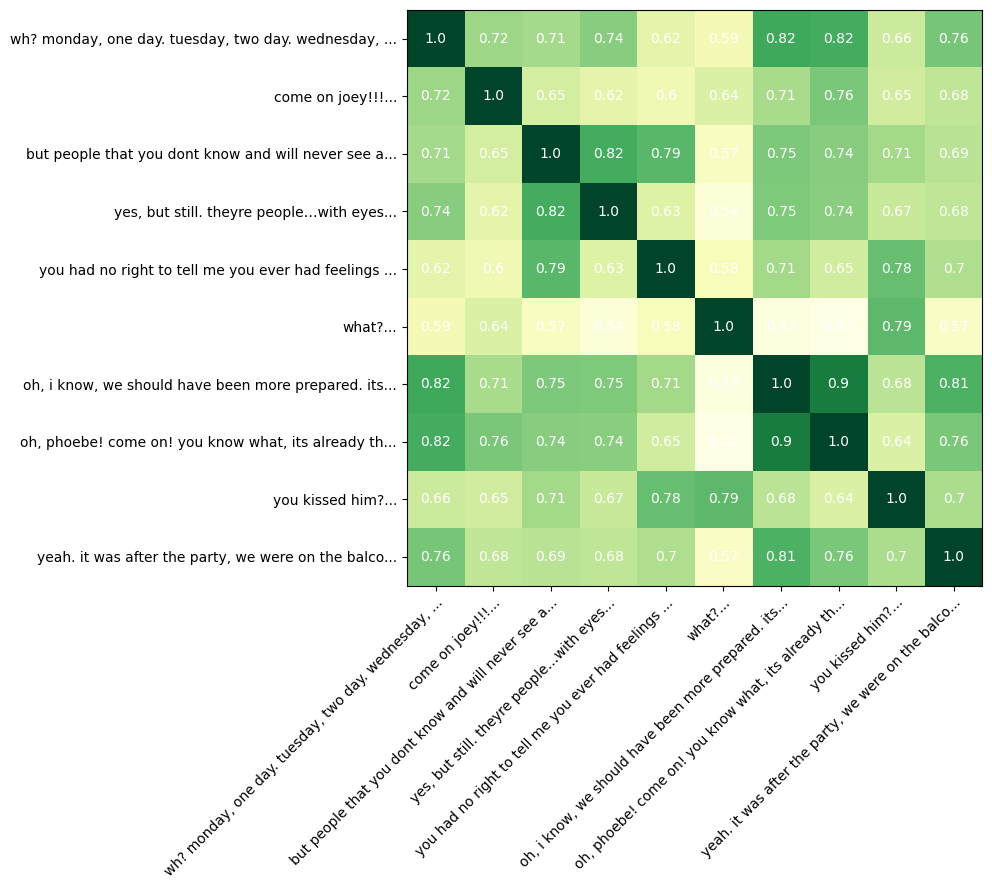

In [ ]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

In [ ]:
df_base = pd.read_csv("rachel_friends.csv")  # read the database into a data frame
df.head(3)  # see first 5 lines

questioner                                           question answerer  \
0       joey                   you're a pain in my ass, geller!   rachel   
1     monica                          why isn't it working out?   rachel   
2     phoebe  or we could use it to call china. see how thos...   rachel   

                                              answer  label  
0  all right, look you guys... look, we appreciat...      1  
1              i don't know... sometimes it doesn't.      1  
2                       yeah? really? no one’s home?      0

In [ ]:
inverted_answer = dict(enumerate(df_base.answer.tolist()))

Create base with the answers

In [ ]:
answer_embeds = [encode(sent, model.bert_tokenizer, model.bert_model, device).squeeze().cpu().detach().numpy() for sent in df_base.answer.tolist()]
answer_embeds = np.array(answer_embeds)
print(answer_embeds.shape)
np.save("bi_bert_answer.npy", answer_embeds)

(8059, 768)


In [ ]:
question_embeds = [encode(sent, model.bert_tokenizer, model.bert_model, device).squeeze().cpu().detach().numpy() for sent in df_base.question.tolist()]
question_embeds = np.array(question_embeds)
print(question_embeds.shape)
np.save("bi_bert_question.npy", question_embeds)

(8059, 768)


In [ ]:
question = "Where are you going?"
question = encode(question, model.bert_tokenizer, model.bert_model, device).squeeze().cpu().detach().numpy()

Try different options for answers

In [ ]:
cosine_similarities = cosine_similarity([question], answer_embeds).flatten()
topk_indices = np.argsort(cosine_similarities, axis=0)[::-1][:5]
topk_indices.tolist()
print("top k answers")
print([inverted_answer[ind] for ind in topk_indices])
print()
print("top answer")
top_indices = np.argmax(cosine_similarities, axis=0)
print(inverted_answer[top_indices])

top k answers
['where are you going?', 'why, where are you going?', 'why aren’t you home yet?!', 'so umm, what time are you supposed to leave?', 'where ya going?']

top answer
where are you going?


In [ ]:
cosine_similarities = cosine_similarity([question], question_embeds).flatten()
topk_indices = np.argsort(cosine_similarities, axis=0)[::-1][:5]
topk_indices.tolist()
print("top k answers")
topk_answers_on_question = [inverted_answer[ind] for ind in topk_indices]
print(topk_answers_on_question)
print()
print("top answer")
top_indices = np.argmax(cosine_similarities, axis=0)
print(inverted_answer[top_indices])

top k answers
['how about you guys?', "oh well, you know, i think it's kinda really important that i go somewhere where there's sun, so i'm sort of...   hey!", 'hi!', 'ooh, the gift shop!', "no, these aren't all my suitcases.  this one's paolo's."]

top answer
how about you guys?


# Let's try cross encoder

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

In [ ]:
# example of next sentence prediction objective used for a cross encoder
tokenized_texts = tokenizer(["I am hungry."], ["Order some food for me"], padding=True, truncation=True)
tokenizer.decode(tokenized_texts["input_ids"][0])

'[CLS] i am hungry. [SEP] order some food for me [SEP]'

In [ ]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer(df.question.tolist(),
                            df.answer.tolist(),
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

CPU times: user 3.3 s, sys: 368 ms, total: 3.66 s
Wall time: 2.18 s


In [ ]:
class CrossFriendsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])

In [ ]:
cross_friends_dataset = CrossFriendsDataset(tokenized_texts, df.label.tolist())

In [ ]:
train_ratio = 0.8
n_total = len(cross_friends_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(cross_friends_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataloader), len(val_dataloader)

(806, 202)

In [ ]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [ ]:
def test_cross_encoder_bert():
    max_length = 128
    model = CrossEncoderBert(max_length=max_length)

    # Check __init__ method
    assert model.max_length == max_length, "Incorrect max_length initialization"
    assert isinstance(model.linear, torch.nn.Linear), "linear is not an instance of torch.nn.Linear"
    assert model.linear.in_features == model.bert_model.config.hidden_size, "Incorrect input size for linear layer"

    # Prepare dummy data for forward method check
    input_text = ["Hello, world!"]
    inputs = model.bert_tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Check forward method
    output = model(input_ids, attention_mask)
    assert output.shape == (1, 1), "Output shape is incorrect"

    print("All checks passed!")

test_cross_encoder_bert()

All checks passed!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrossEncoderBert().to(device)

In [ ]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [ ]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()

def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

In [ ]:
%%time

n_epochs = 2

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/806, Loss = 0.656
Step    64/806, Loss = 0.306
Step   128/806, Loss = 0.312
Step   192/806, Loss = 0.219
Step   256/806, Loss = 0.289
Step   320/806, Loss = 0.177
Step   384/806, Loss = 0.358
Step   448/806, Loss = 0.250
Step   512/806, Loss = 0.246
Step   576/806, Loss = 0.214
Step   640/806, Loss = 0.241
Step   704/806, Loss = 0.191
Step   768/806, Loss = 0.233
Step     0/202, Loss = 0.237
Step    64/202, Loss = 0.225
Step   128/202, Loss = 0.265
Step   192/202, Loss = 0.253

Epoch 2
Step     0/806, Loss = 0.195
Step    64/806, Loss = 0.178
Step   128/806, Loss = 0.223
Step   192/806, Loss = 0.202
Step   256/806, Loss = 0.201
Step   320/806, Loss = 0.225
Step   384/806, Loss = 0.216
Step   448/806, Loss = 0.212
Step   512/806, Loss = 0.211
Step   576/806, Loss = 0.213
Step   640/806, Loss = 0.221
Step   704/806, Loss = 0.221
Step   768/806, Loss = 0.203
Step     0/202, Loss = 0.237
Step    64/202, Loss = 0.225
Step   128/202, Loss = 0.265
Step   192/202, Loss = 0.

In [ ]:
model.bert_model.save_pretrained("models/friends_cross_encoder")

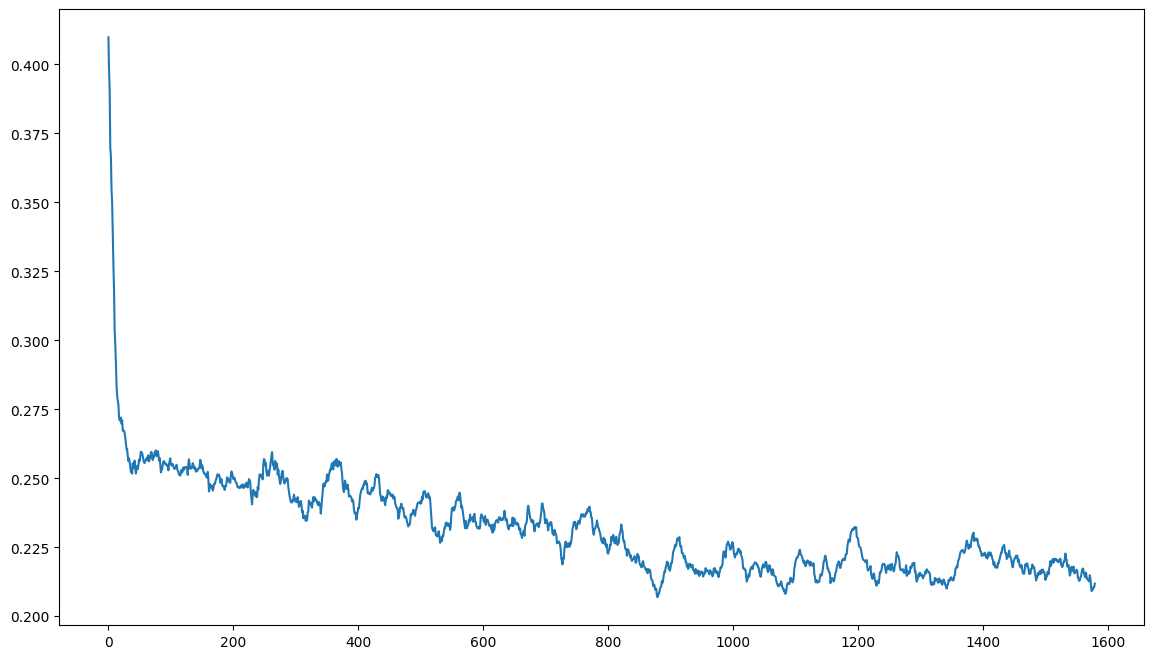

In [ ]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def get_ranked_docs(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :]))  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [ ]:
corpus = topk_answers_on_question
query = "Where are you going?"

In [ ]:
get_ranked_docs(tokenizer, model, bert_model.to(device), query, corpus)

Query - Where are you going? [Finetuned Cross-Encoder]
---
0.63	ooh, the gift shop!
0.63	hi!
0.63	how about you guys?
0.61	no, these aren't all my suitcases.  this one's paolo's.
0.59	oh well, you know, i think it's kinda really important that i go somewhere where there's sun, so i'm sort of...   hey!

Query - Where are you going? [Bert Base]
---
0.50	no, these aren't all my suitcases.  this one's paolo's.
0.49	oh well, you know, i think it's kinda really important that i go somewhere where there's sun, so i'm sort of...   hey!
0.49	hi!
0.48	how about you guys?
0.48	ooh, the gift shop!


In [ ]:
def get_cross_answer(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed


    # Process scores for finetuned model
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argmax(scores)
    print(f"{corpus[scores_ix]}")

In [ ]:
get_cross_answer(tokenizer, model, bert_model.to(device), query, corpus)

ooh, the gift shop!
